In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [2]:
df=pd.read_csv('learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=0)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [3]:
class DNN_4(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2):
        super(DNN_4, self).__init__()
        self.layer1 = nn.Linear(input_dim,32)
        self.layer2 = nn.Linear(32,16)
        self.layer3 = nn.Linear(16, 8)
        self.layer4 = nn.Linear(8, 4)
        self.output_layer = nn.Linear(4, 1)

        self.bn1=nn.BatchNorm1d(32)
        self.bn2=nn.BatchNorm1d(16)
        self.bn3=nn.BatchNorm1d(8)
        self.bn4=nn.BatchNorm1d(4)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.layer2(x)))
    

        x = torch.relu(self.bn3(self.layer3(x)))
        

        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout2(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [4]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

Optunaの設定

In [5]:
def objective(trial):
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整

    # モデル定義
    model = DNN_4(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >= 0.5).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 評価指標の計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [6]:
device_id = 0  # 使用するGPUのID（0または1）
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-18 13:39:36,943] A new study created in memory with name: no-name-7bcbe35c-46ad-4f65-9cf3-592b40defc3d
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:39:39,983] Trial 0 finished with value: 0.0 and parameters: {'dropout1': 0.4, 'dropout2': 0.2, 'learning_rate': 0.04992251569231189, 'weight_decay': 0.004929721645595585}. Best is trial 0 with value: 0.0.


Early stopping at epoch 13
Final MCC: 0.0000


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:39:44,295] Trial 1 finished with value: 0.0 and parameters: {'dropout1': 0.25, 'dropout2': 0.1, 'learning_rate': 0.023397132062884858, 'weight_decay': 0.0005119917425771806}. Best is trial 0 with value: 0.0.


Early stopping at epoch 30
Final MCC: 0.0000


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:39:46,829] Trial 2 finished with value: 0.0 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.25, 'learning_rate': 0.03418925584842156, 'weight_decay': 0.0035870730321490595}. Best is trial 0 with value: 0.0.


Early stopping at epoch 17
Final MCC: 0.0000


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:39:51,449] Trial 3 finished with value: 0.0063250650052013415 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'learning_rate': 0.0035364674321454884, 'weight_decay': 0.0027479783201590433}. Best is trial 3 with value: 0.0063250650052013415.


Early stopping at epoch 33
Final MCC: 0.0063


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:40:04,388] Trial 4 finished with value: 0.0 and parameters: {'dropout1': 0.45, 'dropout2': 0.45, 'learning_rate': 0.00010167486143123375, 'weight_decay': 0.01314683026646166}. Best is trial 3 with value: 0.0063250650052013415.


Final MCC: 0.0000


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:40:06,670] Trial 5 finished with value: 0.0 and parameters: {'dropout1': 0.5, 'dropout2': 0.2, 'learning_rate': 0.00247948184536754, 'weight_decay': 0.09169480649024819}. Best is trial 3 with value: 0.0063250650052013415.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This featur

Early stopping at epoch 16
Final MCC: 0.0000


[I 2024-12-18 13:40:06,915] Trial 7 pruned. 
[I 2024-12-18 13:40:10,608] Trial 8 finished with value: 0.18150533187518986 and parameters: {'dropout1': 0.0, 'dropout2': 0.25, 'learning_rate': 0.00039276213111240387, 'weight_decay': 0.0016366986252299973}. Best is trial 8 with value: 0.18150533187518986.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:40:10,740] Trial 9 pruned. 


Early stopping at epoch 27
Final MCC: 0.1815


[I 2024-12-18 13:40:21,262] Trial 10 finished with value: 0.2586502677259226 and parameters: {'dropout1': 0.0, 'dropout2': 0.4, 'learning_rate': 0.0001642906563735688, 'weight_decay': 0.00010595542387373175}. Best is trial 10 with value: 0.2586502677259226.


Early stopping at epoch 80
Final MCC: 0.2587


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:40:34,222] Trial 11 finished with value: 0.0 and parameters: {'dropout1': 0.0, 'dropout2': 0.4, 'learning_rate': 0.00011420279103969042, 'weight_decay': 8.716733663556518e-05}. Best is trial 10 with value: 0.2586502677259226.


Final MCC: 0.0000


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:40:42,255] Trial 12 finished with value: 0.17091736051399203 and parameters: {'dropout1': 0.1, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00043830533785453303, 'weight_decay': 8.786664928470112e-05}. Best is trial 10 with value: 0.2586502677259226.


Early stopping at epoch 59
Final MCC: 0.1709


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:40:50,829] Trial 13 finished with value: 0.1972510904018033 and parameters: {'dropout1': 0.1, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0003617684404681853, 'weight_decay': 1.0999087048845206e-05}. Best is trial 10 with value: 0.2586502677259226.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has bee

Early stopping at epoch 64
Final MCC: 0.1973


[I 2024-12-18 13:40:53,988] Trial 15 finished with value: 0.18863031397110383 and parameters: {'dropout1': 0.1, 'dropout2': 0.0, 'learning_rate': 0.000998314008747073, 'weight_decay': 3.709714466872837e-05}. Best is trial 10 with value: 0.2586502677259226.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:40:54,150] Trial 16 pruned. 


Early stopping at epoch 22
Final MCC: 0.1886


[I 2024-12-18 13:41:07,195] Trial 17 finished with value: -0.04413170355901845 and parameters: {'dropout1': 0.2, 'dropout2': 0.5, 'learning_rate': 0.00022541450957793408, 'weight_decay': 0.00026218923906220587}. Best is trial 10 with value: 0.2586502677259226.


Final MCC: -0.0441


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:41:13,066] Trial 18 finished with value: 0.2186729725346097 and parameters: {'dropout1': 0.05, 'dropout2': 0.4, 'learning_rate': 0.0009386989805580026, 'weight_decay': 3.771943225933225e-05}. Best is trial 10 with value: 0.2586502677259226.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in 

Early stopping at epoch 43
Final MCC: 0.2187


[I 2024-12-18 13:41:17,430] Trial 20 finished with value: 0.21457661038288361 and parameters: {'dropout1': 0.2, 'dropout2': 0.4, 'learning_rate': 0.0007209094069354525, 'weight_decay': 2.571538304783355e-05}. Best is trial 10 with value: 0.2586502677259226.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:41:17,621] Trial 21 pruned. 


Early stopping at epoch 31
Final MCC: 0.2146


[I 2024-12-18 13:41:17,790] Trial 22 pruned. 
[I 2024-12-18 13:41:17,962] Trial 23 pruned. 
[I 2024-12-18 13:41:24,070] Trial 24 finished with value: 0.13633669229751863 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0006589899852421262, 'weight_decay': 6.317014006818319e-05}. Best is trial 10 with value: 0.2586502677259226.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_d

Early stopping at epoch 46
Final MCC: 0.1363


[I 2024-12-18 13:41:27,712] Trial 26 finished with value: 0.12550723431496646 and parameters: {'dropout1': 0.05, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0016888263138803215, 'weight_decay': 0.0004128270082925146}. Best is trial 10 with value: 0.2586502677259226.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:41:27,884] Trial 27 pruned. 


Early stopping at epoch 26
Final MCC: 0.1255


[I 2024-12-18 13:41:28,048] Trial 28 pruned. 
[I 2024-12-18 13:41:28,206] Trial 29 pruned. 
[I 2024-12-18 13:41:28,382] Trial 30 pruned. 
[I 2024-12-18 13:41:38,801] Trial 31 finished with value: 0.14376765491396307 and parameters: {'dropout1': 0.1, 'dropout2': 0.2, 'learning_rate': 0.0002673275202378924, 'weight_decay': 1.797896155648725e-05}. Best is trial 10 with value: 0.2586502677259226.


Early stopping at epoch 77
Final MCC: 0.1438


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:41:47,003] Trial 32 finished with value: 0.13391407873274247 and parameters: {'dropout1': 0.05, 'dropout2': 0.1, 'learning_rate': 0.0003528924755034694, 'weight_decay': 1.4969317533998532e-05}. Best is trial 10 with value: 0.2586502677259226.


Early stopping at epoch 63
Final MCC: 0.1339


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:41:58,353] Trial 33 finished with value: 0.29297095967951603 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.2, 'learning_rate': 0.0001503334697218968, 'weight_decay': 1.0052373261636932e-05}. Best is trial 33 with value: 0.29297095967951603.


Early stopping at epoch 85
Final MCC: 0.2930


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:41:59,880] Trial 34 finished with value: 0.1788990364900566 and parameters: {'dropout1': 0.25, 'dropout2': 0.25, 'learning_rate': 0.00017862492365597774, 'weight_decay': 4.5376316499068125e-05}. Best is trial 33 with value: 0.29297095967951603.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated

Early stopping at epoch 10
Final MCC: 0.1789


[I 2024-12-18 13:42:05,402] Trial 36 finished with value: 0.1492890425853943 and parameters: {'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0011500413157714566, 'weight_decay': 2.4915464036466517e-05}. Best is trial 33 with value: 0.29297095967951603.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:42:05,552] Trial 37 pruned. 


Early stopping at epoch 40
Final MCC: 0.1493


[I 2024-12-18 13:42:11,199] Trial 38 finished with value: 0.13182987142274724 and parameters: {'dropout1': 0.0, 'dropout2': 0.25, 'learning_rate': 0.0005636333221679473, 'weight_decay': 0.03648391277500996}. Best is trial 33 with value: 0.29297095967951603.


Early stopping at epoch 43
Final MCC: 0.1318


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:42:24,320] Trial 39 finished with value: 0.3077954447433503 and parameters: {'dropout1': 0.25, 'dropout2': 0.45, 'learning_rate': 0.00013855525296660318, 'weight_decay': 5.451148803782984e-05}. Best is trial 39 with value: 0.3077954447433503.


Final MCC: 0.3078


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:42:36,946] Trial 40 finished with value: 0.3185691354916671 and parameters: {'dropout1': 0.25, 'dropout2': 0.5, 'learning_rate': 0.00013997110554236276, 'weight_decay': 0.00032639891654024516}. Best is trial 40 with value: 0.3185691354916671.


Final MCC: 0.3186


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:42:49,817] Trial 41 finished with value: 0.10511246717285631 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.5, 'learning_rate': 0.0001420620585750935, 'weight_decay': 0.0003424396346580477}. Best is trial 40 with value: 0.3185691354916671.


Final MCC: 0.1051


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:43:02,374] Trial 42 finished with value: 0.1885363301716139 and parameters: {'dropout1': 0.25, 'dropout2': 0.45, 'learning_rate': 0.00010190351569351555, 'weight_decay': 0.0006530799498357971}. Best is trial 40 with value: 0.3185691354916671.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated i

Final MCC: 0.1885


[I 2024-12-18 13:43:02,665] Trial 44 pruned. 
[I 2024-12-18 13:43:15,324] Trial 45 finished with value: 0.20486014157027838 and parameters: {'dropout1': 0.4, 'dropout2': 0.5, 'learning_rate': 0.00026078461458073875, 'weight_decay': 5.4955257211721694e-05}. Best is trial 40 with value: 0.3185691354916671.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:43:15,474] Trial 46 pruned. 


Final MCC: 0.2049


[I 2024-12-18 13:43:15,631] Trial 47 pruned. 
[I 2024-12-18 13:43:15,782] Trial 48 pruned. 
[I 2024-12-18 13:43:28,703] Trial 49 finished with value: 0.36769590915606865 and parameters: {'dropout1': 0.1, 'dropout2': 0.5, 'learning_rate': 0.00010505076141594679, 'weight_decay': 0.00010196030804872456}. Best is trial 49 with value: 0.36769590915606865.


Final MCC: 0.3677


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:43:41,492] Trial 50 finished with value: 0.3594621940102946 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.5, 'learning_rate': 0.00010150019164513776, 'weight_decay': 0.0006610523132491616}. Best is trial 49 with value: 0.36769590915606865.


Final MCC: 0.3595


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:43:55,107] Trial 51 finished with value: 0.4011142142321774 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.5, 'learning_rate': 0.00011190563675127609, 'weight_decay': 0.0005543065395801654}. Best is trial 51 with value: 0.4011142142321774.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has bee

Final MCC: 0.4011


[I 2024-12-18 13:43:55,394] Trial 53 pruned. 
[I 2024-12-18 13:44:08,225] Trial 54 finished with value: 0.27332085931669925 and parameters: {'dropout1': 0.1, 'dropout2': 0.5, 'learning_rate': 0.00018588141064220036, 'weight_decay': 0.0004706174229222024}. Best is trial 51 with value: 0.4011142142321774.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:44:08,382] Trial 55 pruned. 


Final MCC: 0.2733


[I 2024-12-18 13:44:08,539] Trial 56 pruned. 
[I 2024-12-18 13:44:08,687] Trial 57 pruned. 
[I 2024-12-18 13:44:08,815] Trial 58 pruned. 
[I 2024-12-18 13:44:08,931] Trial 59 pruned. 
[I 2024-12-18 13:44:09,071] Trial 60 pruned. 
[I 2024-12-18 13:44:22,118] Trial 61 finished with value: 0.3271136737080566 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.5, 'learning_rate': 0.0001658039588682159, 'weight_decay': 0.0004375175571955273}. Best is trial 51 with value: 0.4011142142321774.


Final MCC: 0.3271


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:44:32,932] Trial 62 finished with value: 0.24205714393292385 and parameters: {'dropout1': 0.1, 'dropout2': 0.5, 'learning_rate': 0.00012612811892620757, 'weight_decay': 0.000508050272252095}. Best is trial 51 with value: 0.4011142142321774.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in 

Early stopping at epoch 88
Final MCC: 0.2421


[I 2024-12-18 13:44:45,809] Trial 64 finished with value: -0.015756141340390366 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.45, 'learning_rate': 0.00016378603359559537, 'weight_decay': 0.0004002735999811488}. Best is trial 51 with value: 0.4011142142321774.


Final MCC: -0.0158


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:45:00,054] Trial 65 finished with value: 0.3225698161500912 and parameters: {'dropout1': 0.2, 'dropout2': 0.5, 'learning_rate': 0.00012075622098465548, 'weight_decay': 0.0009485090491031892}. Best is trial 51 with value: 0.4011142142321774.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in 

Final MCC: 0.3226


[I 2024-12-18 13:45:14,820] Trial 67 finished with value: 0.17181727389450577 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.45, 'learning_rate': 0.00010261298166252465, 'weight_decay': 0.0015256393002415457}. Best is trial 51 with value: 0.4011142142321774.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:45:14,975] Trial 68 pruned. 


Final MCC: 0.1718


[I 2024-12-18 13:45:27,431] Trial 69 finished with value: 0.10065756070235617 and parameters: {'dropout1': 0.25, 'dropout2': 0.45, 'learning_rate': 0.00023338637819967357, 'weight_decay': 7.203117139371467e-05}. Best is trial 51 with value: 0.4011142142321774.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:45:27,564] Trial 70 pruned. 


Final MCC: 0.1007


[I 2024-12-18 13:45:27,730] Trial 71 pruned. 
[I 2024-12-18 13:45:27,892] Trial 72 pruned. 
[I 2024-12-18 13:45:29,267] Trial 73 finished with value: 0.0 and parameters: {'dropout1': 0.25, 'dropout2': 0.5, 'learning_rate': 0.00016900189554988436, 'weight_decay': 0.00010135286456877237}. Best is trial 51 with value: 0.4011142142321774.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13

Early stopping at epoch 10
Final MCC: 0.0000


[I 2024-12-18 13:45:29,591] Trial 75 pruned. 
[I 2024-12-18 13:45:29,754] Trial 76 pruned. 
[I 2024-12-18 13:45:43,371] Trial 77 finished with value: 0.36550332591995643 and parameters: {'dropout1': 0.2, 'dropout2': 0.5, 'learning_rate': 0.00015812561320734822, 'weight_decay': 1.0308120202665924e-05}. Best is trial 51 with value: 0.4011142142321774.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[

Final MCC: 0.3655


[I 2024-12-18 13:45:43,718] Trial 79 pruned. 
[I 2024-12-18 13:45:43,892] Trial 80 pruned. 
[I 2024-12-18 13:45:44,059] Trial 81 pruned. 
[I 2024-12-18 13:45:57,894] Trial 82 finished with value: 0.3431303630013248 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'learning_rate': 0.00010117643800341691, 'weight_decay': 1.0077456749381147e-05}. Best is trial 51 with value: 0.4011142142321774.


Final MCC: 0.3431


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:46:11,102] Trial 83 finished with value: 0.3270901098701374 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'learning_rate': 0.00013323891155207326, 'weight_decay': 1.200519945232557e-05}. Best is trial 51 with value: 0.4011142142321774.


Final MCC: 0.3271


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:46:25,395] Trial 84 finished with value: 0.33275287229798706 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'learning_rate': 0.00010397020793868458, 'weight_decay': 1.1410367086413977e-05}. Best is trial 51 with value: 0.4011142142321774.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has b

Final MCC: 0.3328


[I 2024-12-18 13:46:27,062] Trial 86 finished with value: 0.0 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'learning_rate': 0.00019521467628842042, 'weight_decay': 1.167861681033658e-05}. Best is trial 51 with value: 0.4011142142321774.


Early stopping at epoch 10
Final MCC: 0.0000


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:46:39,605] Trial 87 finished with value: 0.2935346578833186 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.45, 'learning_rate': 0.00011831433983079024, 'weight_decay': 1.6548502518771666e-05}. Best is trial 51 with value: 0.4011142142321774.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has b

Final MCC: 0.2935


[I 2024-12-18 13:46:39,952] Trial 89 pruned. 
[I 2024-12-18 13:46:40,116] Trial 90 pruned. 
[I 2024-12-18 13:46:40,279] Trial 91 pruned. 
[I 2024-12-18 13:46:40,439] Trial 92 pruned. 
[I 2024-12-18 13:46:40,596] Trial 93 pruned. 
[I 2024-12-18 13:46:51,088] Trial 94 finished with value: 0.27722486391194895 and parameters: {'dropout1': 0.25, 'dropout2': 0.45, 'learning_rate': 0.00013524870197868276, 'weight_decay': 0.00046192779782528375}. Best is trial 51 with value: 0.4011142142321774.


Final MCC: 0.2772


/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41819/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:47:04,590] Trial 95 finished with value: 0.0 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'learning_rate': 0.00020534578502436776, 'weight_decay': 1.569365560772321e-05}. Best is trial 51 with value: 0.4011142142321774.
/tmp/ipykernel_41819/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in

Final MCC: 0.0000


[I 2024-12-18 13:47:04,936] Trial 97 pruned. 
[I 2024-12-18 13:47:05,102] Trial 98 pruned. 
[I 2024-12-18 13:47:05,279] Trial 99 pruned. 


Best Parameters:  {'dropout1': 0.15000000000000002, 'dropout2': 0.5, 'learning_rate': 0.00011190563675127609, 'weight_decay': 0.0005543065395801654}
Best Validation F1:  0.4011142142321774


In [7]:
best_params = study.best_params

# JSON形式で保存
with open("optim_param/optim_DNN_4_params.json", "w") as f:
    json.dump(best_params, f)

print("Best parameters saved to 'best_params.json'")

Best parameters saved to 'best_params.json'


Epoch [1/150], Loss: 0.8750
Epoch [1/150], Train Loss: 0.8750, Val Loss: 0.7543
Epoch [2/150], Loss: 0.8664
Epoch [2/150], Train Loss: 0.8664, Val Loss: 0.7915
Epoch [3/150], Loss: 0.8502
Epoch [3/150], Train Loss: 0.8502, Val Loss: 0.7834
Epoch [4/150], Loss: 0.8368
Epoch [4/150], Train Loss: 0.8368, Val Loss: 0.7759
Epoch [5/150], Loss: 0.8375
Epoch [5/150], Train Loss: 0.8375, Val Loss: 0.7686
Epoch [6/150], Loss: 0.8180
Epoch [6/150], Train Loss: 0.8180, Val Loss: 0.7642
Epoch [7/150], Loss: 0.8258
Epoch [7/150], Train Loss: 0.8258, Val Loss: 0.7588
Epoch [8/150], Loss: 0.8251
Epoch [8/150], Train Loss: 0.8251, Val Loss: 0.7564
Epoch [9/150], Loss: 0.8130
Epoch [9/150], Train Loss: 0.8130, Val Loss: 0.7523
Epoch [10/150], Loss: 0.8003
Epoch [10/150], Train Loss: 0.8003, Val Loss: 0.7518
Epoch [11/150], Loss: 0.8029
Epoch [11/150], Train Loss: 0.8029, Val Loss: 0.7513
Epoch [12/150], Loss: 0.7973
Epoch [12/150], Train Loss: 0.7973, Val Loss: 0.7466
Epoch [13/150], Loss: 0.7899
Epoch

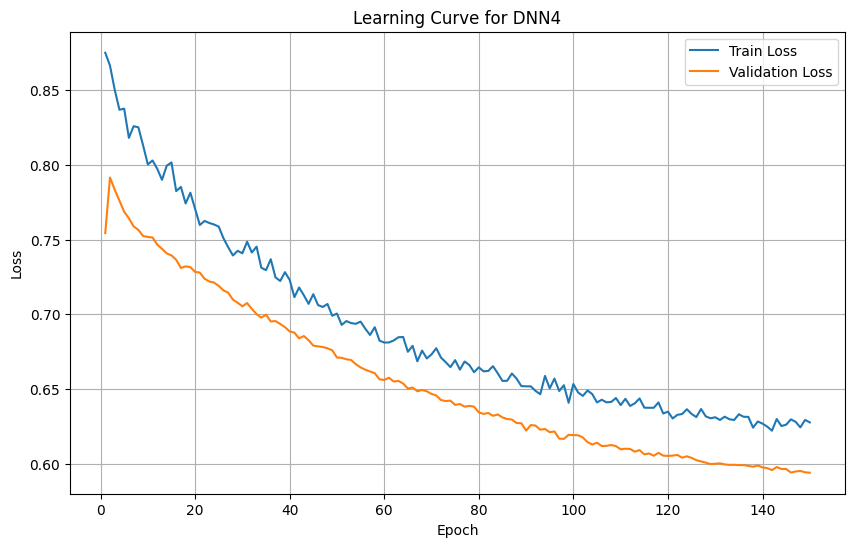

In [8]:
best_params=study.best_params
model = DNN_4(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"]).to(device)


# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=150
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN4')
plt.legend()
plt.grid()
plt.show()

Accuracy: 59.68%
Precision: 0.4611
Recall: 0.4893
F1 Score: 0.4748
Matthews Correlation Coefficient: 0.1482
Specificity: 0.6606


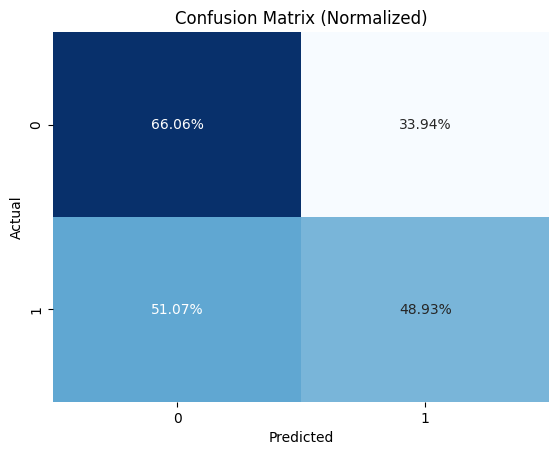

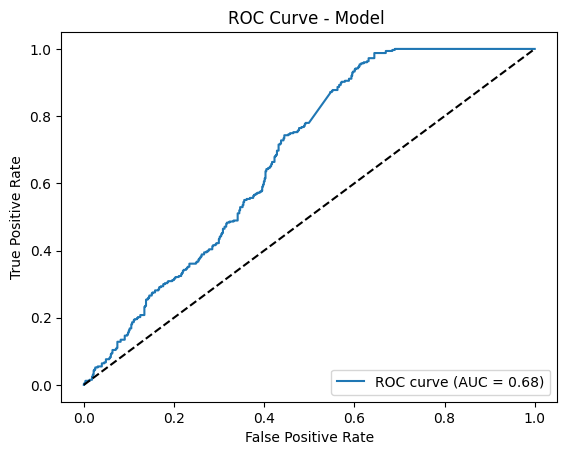

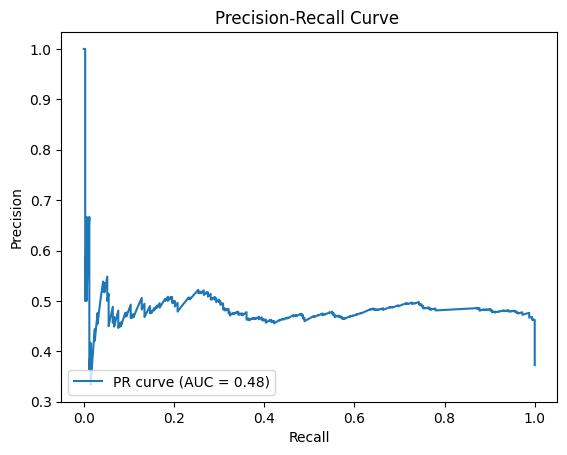

In [9]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >=0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [10]:
# モデルと構造を保存
torch.save(model.state_dict(), 'model_params/DNN_4.pth')



In [11]:
from torchsummary import summary
summary(model, input_size=(X_train_tensor.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             960
       BatchNorm1d-2                   [-1, 32]              64
           Dropout-3                   [-1, 32]               0
            Linear-4                   [-1, 16]             528
       BatchNorm1d-5                   [-1, 16]              32
            Linear-6                    [-1, 8]             136
       BatchNorm1d-7                    [-1, 8]              16
            Linear-8                    [-1, 4]              36
       BatchNorm1d-9                    [-1, 4]               8
          Dropout-10                    [-1, 4]               0
           Linear-11                    [-1, 1]               5
Total params: 1,785
Trainable params: 1,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back